In [15]:
import sys
import numpy as np
import os
import cv2
import h5py
import logging
import tensorflow as tf
from math import log10
from collections import OrderedDict

import matplotlib.pyplot as plt
from typing import Iterator, Tuple
from shapeSorter import SimpleSegmentationDataset
from layers import weight_variable,bias_variable,conv2d,weight_variable_devonc,deconv2d,max_pool,pixel_wise_softmax,cross_entropy,features_concat,pixel_wise_softmax_2

In [16]:
##########
GLOBAL_PATH='MODEL_SHAPE/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        

##############

        
INPUT_CHANNELS=3
OUTPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'shape_model.ckpt'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=1000
DROPOUT=0.9#0.8
DEFAULT_BATCH_SIZE = 128#50
DEFAULT_EPOCHS = 5#5
DEFAULT_ITERATIONS =38#98
DEFAULT_VALID=10#70
DISPLAY_STEP=20

In [17]:
def create_conv_net(x, keep_prob, channels, n_class, layers=4, features_root=32, filter_size=3, pool_size=2,phase_train=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    """

    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]),'reshape_for_network')
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []

    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    
    in_size = 1000
    size = in_size
    
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))

        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        

        conv1 = conv2d(in_node, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        conv2=conv2+conv1
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2,layer))
        biases.append((b1, b2,layer))
        convs.append((conv1, conv2))

        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]

    # up layers
    for layer in range(layers-2, -1, -1):
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = features_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        conv2=conv2+conv1
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2,layer))
        biases.append((b1, b2,layer))
        convs.append((conv1, conv2))
        
        size *= 2


    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
#     conv=tf.contrib.layers.batch_norm(conv, center=True, scale=True, is_training=phase_train)
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    

    variables = []
    for w1,w2,layer in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2,layer in biases:
        variables.append(b2)
        variables.append(b2)
    

    
    return output_map, variables, int(in_size - size)



In [18]:
class CustomCNN():
    
    def __init__(self, channels=3, n_class=3, cost_kwargs={}, **kwargs):
        """
        Initializes the custom CNN 
        """
        self.n_class = n_class
        tf.reset_default_graph()
        
        self.X_placeholder = tf.placeholder(tf.float32, [None, None, None, INPUT_CHANNELS], name='X_placeholder')
        self.y_placeholder = tf.placeholder(tf.float32, [None, None, None,NB_CLASSES], name='y_placeholder')
        self.keep_prob = tf.placeholder(tf.float32)
        self.phase_train = tf.placeholder(tf.bool, name='phase_train')

        logits, self.variables, self.offset = create_conv_net(self.X_placeholder, self.keep_prob, channels, n_class, **kwargs)
        
        self.cross_entropy = tf.reduce_mean(cross_entropy(self.y_placeholder,logits))
#         self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y_placeholder, [-1, n_class]),
#                                                           tf.reshape(logits, [-1, n_class])))
        self.cost=self.cross_entropy
#         self.gradients_node = tf.gradients(self.cross_entropy, self.variables)
                                                  
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y_placeholder, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        
    def save(self, sess,saver, model_path,step):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param saver: saver of the model
        :param model_path: path to file system location
        :step: step of the iterations during training when the model is stored
        """
       
        save_path=saver.save(sess, model_path,global_step=step)
        
        return save_path

    
    def restore(self, sess,saver, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param saver: saver of the model
        :param model_path: path to file system checkpoint location
        """

        print("Reading checkpoints...")
        saver.restore(sess, model_path)
        summary="Model restored from file: %s" % (model_path)
        print(summary)
        return True
        
    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.X_placeholder: x_test, self.y_placeholder: y_dummy, self.keep_prob: 1.})
            
        return prediction
        
        
       

In [19]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer ->learning_rate, decay_rate,momentum (momentum) or learning_rate (adam)   
    """
    def __init__(self, net, batch_size=30, optimizer="adam", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        self.learning_rate_ph=tf.placeholder(tf.float32, shape=[])
        self.learning_rate=0.0001
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        elif self.optimizer=="gradient_descent":
            optimizer =tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate_ph).minimize(self.net.cost)
       
        return optimizer
    
    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0)
        
#         self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))

        self.optimizer = self._get_optimizer(training_iters, global_step)        
        init = tf.global_variables_initializer()
        
        self.prediction_path = prediction_path
        
        
        
        
        return init
    
    def train(self, data_provider_path, save_path='', restore_path='', training_iters=4, epochs=3, dropout=0.75, display_step=1, validation_batch_size=30,restore=False,rec_save=1, prediction_path = ''):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """

        #STORE PSNR for ANALYSIS
        loss_train=np.zeros(training_iters*epochs)
        file_train = open(data_provider_path+'loss_train.txt','w') 
        loss_verif=np.zeros(epochs)
        file_verif = open(data_provider_path+'loss_verif.txt','w') 
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        init = self._initialize(training_iters, save_path, restore, prediction_path)
        saver = tf.train.Saver()
        with tf.Session() as sess:        
            sess.run(init)
            
            if restore:
                self.net.restore(sess,saver,restore_path )
            else:
                sess.run(init)

            val_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=validation_batch_size)
            X_val,Y_val=val_generator.__getitem__()

#             X_val=standardize(X_val)


            self.store_prediction(sess, X_val, Y_val, "_init",validation_batch_size)
        
            train_len = self.batch_size*training_iters

            training_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=train_len)
            X_train,Y_train=training_generator.__getitem__()
                
            logging.info("Start optimization")
            
#             avg_gradients = None
            counter=0
            for epoch in range(epochs):
                total_loss = 0

                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    step_batch=step-(epoch*training_iters)
                    batch_x= X_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
                    batch_y =Y_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
#                     batch_x=standardize(batch_x)
                    
                    # Run optimization op (backprop)
#                   _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
#                                                       feed_dict={self.net.X_placeholder: batch_x,
#                                                                  self.net.y_placeholder: batch_y,
#                                                                  self.net.keep_prob: dropout,self.net.phase_train:True})
                    _, loss, lr = sess.run((self.optimizer, self.net.cost, self.learning_rate_node), 
                                                      feed_dict={self.net.X_placeholder: batch_x,
                                                                 self.net.y_placeholder: batch_y,
                                                                 self.net.keep_prob: dropout,
                                                                 self.learning_rate_ph:self.learning_rate,
                                                                 self.net.phase_train:True})
#                     _, loss= sess.run((self.optimizer, self.net.cost), 
#                                                       feed_dict={self.net.X_placeholder: batch_x,
#                                                                  self.net.y_placeholder: batch_y,
#                                                                  self.net.keep_prob: dropout,
#                                                                  self.learning_rate_ph:self.learning_rate,
#                                                                  self.net.phase_train:True})

#                     avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
#                     norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
#                     self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, step, batch_x,batch_y)
                        
                    total_loss += loss
                    loss_train[counter]=loss
                    file_train.write(str(loss_train[counter])+'\n')
                    counter += 1
                    if counter % rec_save == 0:
                        self.net.save(sess,saver,save_path, counter)
                        
                    
#                 self.output_epoch_stats(epoch, total_loss, training_iters, self.learning_rate)
                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                
                loss_v=self.store_prediction(sess, X_val, Y_val, "epoch_%s"%epoch,validation_batch_size)
                loss_verif[epoch]=loss_v
                file_verif.write(str(loss_verif[epoch])+'\n')
                
            logging.info("Optimization Finished!")
            
            return save_path, loss_train,loss_verif
        
    def store_prediction(self, sess, batch_x, batch_y, name,validation_batch_size):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.X_placeholder: batch_x, 
                                                             self.net.y_placeholder: batch_y, 
                                                             self.net.keep_prob: 1.,
                                                             self.net.phase_train:False})

        loss,accuracy = sess.run((self.net.cost,self.net.accuracy), feed_dict={self.net.X_placeholder: batch_x, 
                                                       self.net.y_placeholder: batch_y, 
                                                       self.net.keep_prob: 1.,
                                                  self.net.phase_train:False})
        if accuracy>=0.80 :
            self.learning_rate=0.00001

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,batch_y),loss))
        
        plot_summary(prediction,batch_y,validation_batch_size,name,self.prediction_path)
        return loss

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        loss, acc, predictions = sess.run([self.net.cost,self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.X_placeholder: batch_x,
                                                                      self.net.y_placeholder: batch_y,
                                                                      self.net.keep_prob: 1.,
                                                                      self.net.phase_train:False})
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                                    loss,
                                                                                                                    acc,
                                                                                                                    error_rate(predictions, batch_y)))

In [20]:
def standardize(data):
    '''
    Standardize the input data of the network
    :param data to be standardized (size nb_batches x WIDTH x HEIGHT x number of channels) 
    
    returns data standardized size nb_batches x WIDTH x HEIGHT x number of channels 
    
    '''
    WIDTH=data.shape[1]
    HEIGHT=data.shape[2]
    channels=data.shape[3]
    
    mean_t=np.mean(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    std_t=np.std(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=(data-mean_t)/std_t
    
    #For normalization 
    min_t=np.amin(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    max_t=np.amax(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=(data-min_t)/(max_t-min_t)

    return data

def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """
    
    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,batch_size,epoch,prediction_path):
    
    
    fig1, axs1 = plt.subplots(1, batch_size,figsize=(8*batch_size,8))
    suptitle = fig1.suptitle(epoch+' Groundtruth ', fontsize='large')
    fig2, axs2 = plt.subplots(1, batch_size,figsize=(batch_size*8,8))
    suptitle2 = fig2.suptitle(epoch+' Predictions ', fontsize='large')
    labels=np.argmax(labels, 3)
    logits=np.argmax(predictions, 3)
    for i in range(batch_size):  
        axs1[i].imshow(labels[i,:,:])
        plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i,:,:]) 
        axs2[i].imshow(1-logits[i,:,:])
        plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',labels[i,:,:])

    plt.subplots_adjust()
#     suptitle.set_y(0.95)
#     fig.subplots_adjust(top=0.96)
    plt.show()
    plt.show()

# def _update_avg_gradients(avg_gradients, gradients, step):
#     if avg_gradients is None:
#         avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
#     for i in range(len(gradients)):
#         avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
        
#     return avg_gradients


2018-04-03 13:38:51,423 Layers 4, features 32, filter size 3x3, pool size: 2x2
2018-04-03 13:38:54,214 Verification error= 64.6%, loss= 0.1261


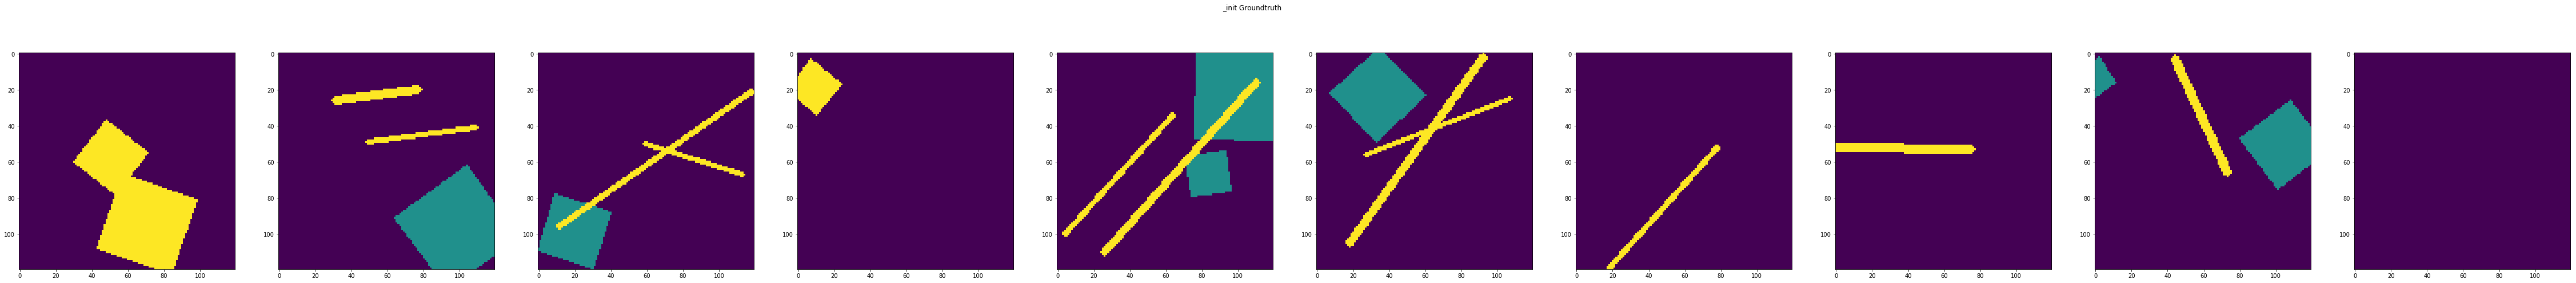

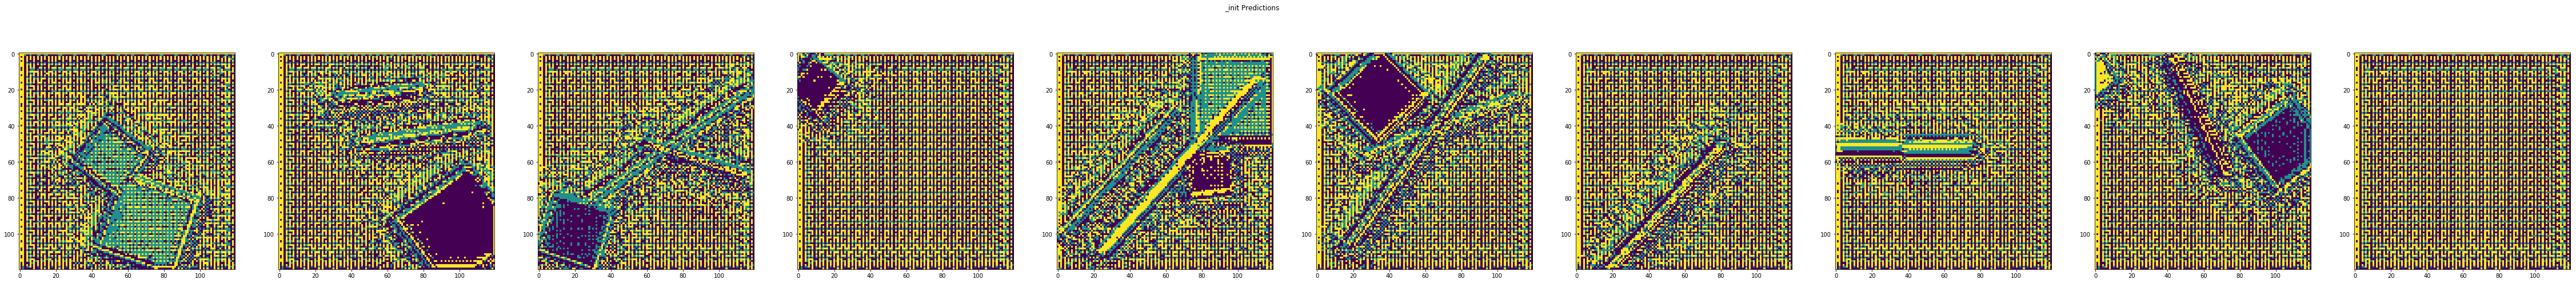

2018-04-03 13:39:04,026 Start optimization
2018-04-03 13:39:07,561 Iter 0, Minibatch Loss= 0.0647, Training Accuracy= 0.3658, Minibatch error= 63.4%
2018-04-03 13:39:23,884 Iter 20, Minibatch Loss= 0.0286, Training Accuracy= 0.9643, Minibatch error= 3.6%
2018-04-03 13:39:37,510 Epoch 0, Average loss: 0.0320, learning rate: 0.0010
2018-04-03 13:39:37,574 Verification error= 2.4%, loss= 0.0187


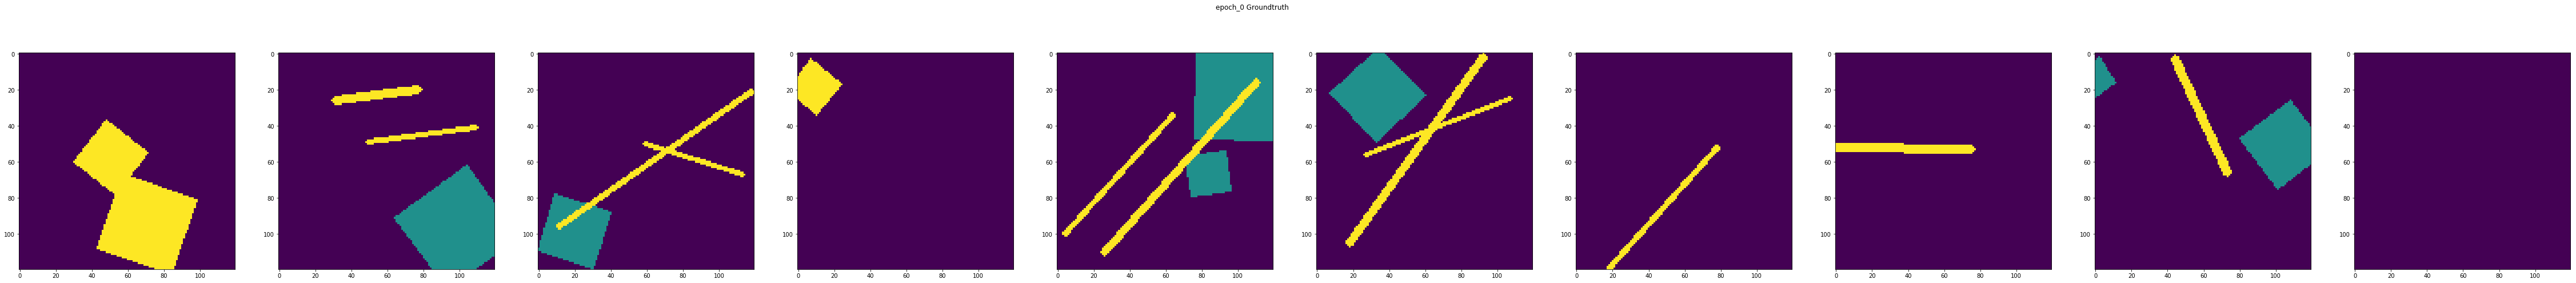

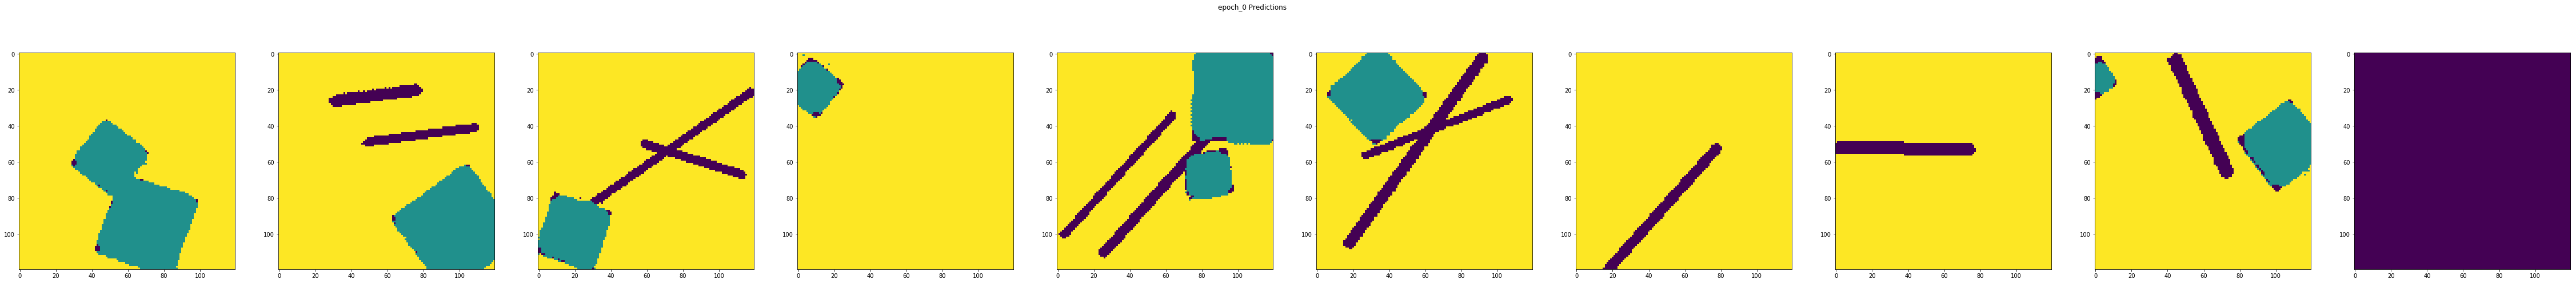

2018-04-03 13:39:42,922 Iter 40, Minibatch Loss= 0.0139, Training Accuracy= 0.9798, Minibatch error= 2.0%
2018-04-03 13:39:59,371 Iter 60, Minibatch Loss= 0.0070, Training Accuracy= 0.9915, Minibatch error= 0.8%
2018-04-03 13:40:11,437 Epoch 1, Average loss: 0.0106, learning rate: 0.0010
2018-04-03 13:40:11,501 Verification error= 0.5%, loss= 0.0100


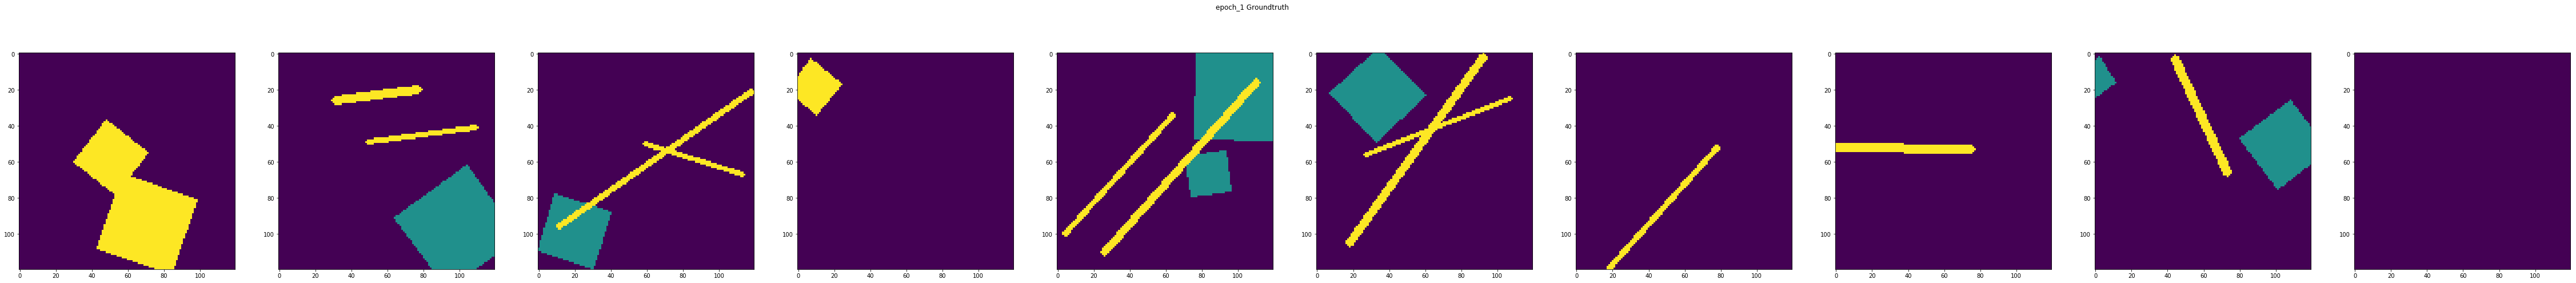

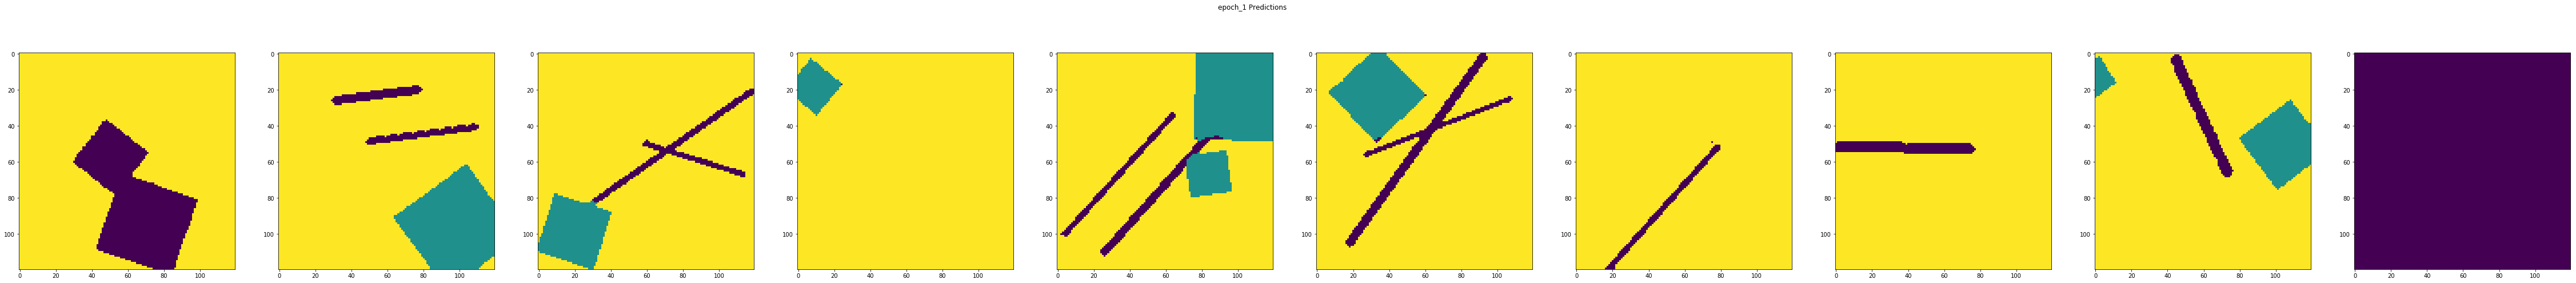

2018-04-03 13:40:18,750 Iter 80, Minibatch Loss= 0.0060, Training Accuracy= 0.9970, Minibatch error= 0.3%
2018-04-03 13:40:35,214 Iter 100, Minibatch Loss= 0.0047, Training Accuracy= 0.9978, Minibatch error= 0.2%


KeyboardInterrupt: 

In [21]:
if __name__ == '__main__':
    model = CustomCNN()


#     root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'
    root_folder=''
    trainer=Trainer(model,DEFAULT_BATCH_SIZE)
    save_path,loss_train,loss_verif=trainer.train( root_folder, MODEL_PATH_SAVE, '', DEFAULT_ITERATIONS,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,False,REC_SAVE, TEST_SAVE)
    
    #SAVE PSNR
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')
    plt.show()
    
    